# Detect deep fack using pretrain resnet18

In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import models, transforms
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import gc

In [ ]:
# del variables
gc.collect()
torch.cuda.empty_cache()

In [ ]:
import requests
from pathlib import Path
from google.colab import drive
import os
import random
from PIL import Image
from torchvision import datasets
from numpy.linalg import norm

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!ls

drive  sample_data


In [ ]:
!pip install -q torchmetrics
from torchmetrics.classification import MulticlassAccuracy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 28.0 MB/s eta 0:00:00


## device agnostic code

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Get dataset

In [ ]:
# wlak through data
def walk_through_dir(dir_path):
  print("in function")
  print(os.walk(dir_path))
  print(iter(os.walk(dir_path)))
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [ ]:
data_path = Path('drive/MyDrive/Course/Sem2/DAI/Assignments/Assignment1/Imagedata')
# PATH = data_path / 
walk_through_dir(data_path)

in function
<generator object walk at 0x7f80af3a5040>
<generator object walk at 0x7f80af3a5040>
There are 2 directories and 0 images in 'drive/MyDrive/Course/Sem2/DAI/Assignments/Assignment1/Imagedata'.
There are 2 directories and 0 images in 'drive/MyDrive/Course/Sem2/DAI/Assignments/Assignment1/Imagedata/Test'.
There are 0 directories and 25 images in 'drive/MyDrive/Course/Sem2/DAI/Assignments/Assignment1/Imagedata/Test/0'.
There are 0 directories and 25 images in 'drive/MyDrive/Course/Sem2/DAI/Assignments/Assignment1/Imagedata/Test/1'.
There are 2 directories and 0 images in 'drive/MyDrive/Course/Sem2/DAI/Assignments/Assignment1/Imagedata/Train'.
There are 0 directories and 25 images in 'drive/MyDrive/Course/Sem2/DAI/Assignments/Assignment1/Imagedata/Train/1'.
There are 0 directories and 25 images in 'drive/MyDrive/Course/Sem2/DAI/Assignments/Assignment1/Imagedata/Train/0'.


In [ ]:
# setup train test path
train_dic = data_path / "Train"
test_dic = data_path / "Test"

train_dic, test_dic

(PosixPath('drive/MyDrive/Course/Sem2/DAI/Assignments/Assignment1/Imagedata/Train'),
 PosixPath('drive/MyDrive/Course/Sem2/DAI/Assignments/Assignment1/Imagedata/Test'))

## Visulize the image

In [ ]:
# set random seed
random.seed(64)

# get all image path list
image_path_list = list(data_path.glob("*/*/*.jpg"))

# get random image path
random_image_path = random.choice(image_path_list)

# get image class from image path
image_class = random_image_path.parent.stem

# open iage
img = Image.open(random_image_path)

# print metadata
print(f"Random Image Path: {random_image_path}")
print(f"Image Class: {image_class}")
print(f"Imahe height: {img.height}")
print(f"Imahe width: {img.width}")
# img

Random Image Path: drive/MyDrive/Course/Sem2/DAI/Assignments/Assignment1/Imagedata/Train/0/11.jpg
Image Class: 0
Imahe height: 6528
Imahe width: 4896


## Transforming data

In [ ]:
# writre transform for image
data_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    # turn image in to torch tensor
    transforms.ToTensor() # this conver px 0 to 255 from 0.0 to 1.0
])

# transforms = transforms.Grayscale()

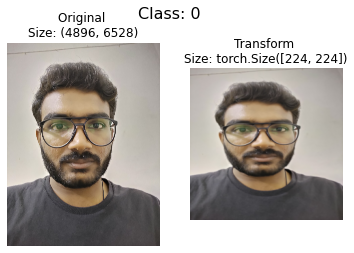

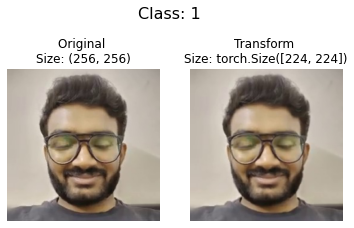

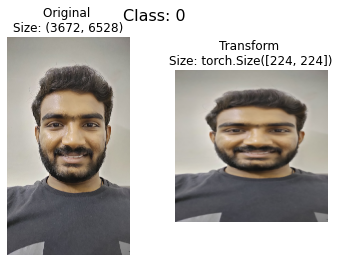

In [ ]:
def plot_transform_image(image_paths, trasform, n=3, seed=64):
  '''
    Plot are in serise of random image

    will oprn n image path from image path anf transform them in to torch tensor

    Args:
      image_paths (list): image path
      trasform (PyTorch transforms): transform the image into given transforms
      n (int, optional): number of random image path
      seed (int, optional): Random seed for random generator | default 64
  '''

  random.seed(seed)
  random_image_path = random.sample(image_paths, k=n)

  for image_path in random_image_path:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f, cmap = 'gray')
      ax[0].set_title(f"Original \nSize: {f.size}")
      ax[0].axis("off")

      # Transform and plot image
      transformed_image = trasform(f).permute(1, 2, 0) # [height, width, color channel]
      # ax[1].imshow(transformed_image[:,:,0], cmap = 'gray')
      ax[1].imshow(transformed_image, cmap = 'gray')
      ax[1].set_title(f"Transform \nSize: {transformed_image[:,:,0].shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transform_image(image_path_list, trasform = data_transform, n = 3)

## Load data using ImageFolder

In [ ]:
train_data = datasets.ImageFolder(root = train_dic, transform = data_transform, target_transform = None)
test_data = datasets.ImageFolder(root = test_dic, transform = data_transform)

print(f"Train Data: {train_data} \nTest Data: {test_data}")

Train Data: Dataset ImageFolder
    Number of datapoints: 50
    Root location: drive/MyDrive/Course/Sem2/DAI/Assignments/Assignment1/Imagedata/Train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           ) 
Test Data: Dataset ImageFolder
    Number of datapoints: 50
    Root location: drive/MyDrive/Course/Sem2/DAI/Assignments/Assignment1/Imagedata/Test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


In [ ]:
# class name
class_names = train_data.classes
class_names

['0', '1']

In [ ]:
# inx
class_to_idx = train_data.class_to_idx
class_to_idx

{'0': 0, '1': 1}

In [ ]:
img, label = train_data[0][0], train_data[0][1]
print(f"image tensor:\n{img}")
print(f"image shape: {img.shape}")
print(f"image type: {type(img)}")
print(f"image label: {label}")
print(f"image label type: {type(label)}")

image tensor:
tensor([[[0.6039, 0.6118, 0.6235,  ..., 0.5725, 0.5647, 0.5608],
         [0.6118, 0.6196, 0.6235,  ..., 0.5922, 0.5843, 0.5725],
         [0.6118, 0.6157, 0.6196,  ..., 0.5961, 0.5922, 0.5804],
         ...,
         [0.2353, 0.2392, 0.2431,  ..., 0.2588, 0.2196, 0.2039],
         [0.2392, 0.2431, 0.2431,  ..., 0.3843, 0.3216, 0.2549],
         [0.2431, 0.2471, 0.2510,  ..., 0.4196, 0.4039, 0.3765]],

        [[0.5922, 0.6000, 0.6078,  ..., 0.5686, 0.5608, 0.5569],
         [0.6000, 0.6078, 0.6118,  ..., 0.5843, 0.5804, 0.5725],
         [0.6000, 0.6078, 0.6078,  ..., 0.5882, 0.5882, 0.5765],
         ...,
         [0.2275, 0.2314, 0.2353,  ..., 0.2510, 0.2118, 0.1961],
         [0.2314, 0.2353, 0.2353,  ..., 0.3765, 0.3098, 0.2471],
         [0.2353, 0.2392, 0.2431,  ..., 0.4118, 0.3961, 0.3647]],

        [[0.5686, 0.5725, 0.5765,  ..., 0.5294, 0.5255, 0.5216],
         [0.5686, 0.5765, 0.5765,  ..., 0.5490, 0.5451, 0.5333],
         [0.5686, 0.5725, 0.5725,  ..., 0.56

Original image shape: torch.Size([3, 224, 224]) --> [color_channel, height, width]
Permuted image shape: torch.Size([224, 224, 3]) --> [height, width, color_channel]


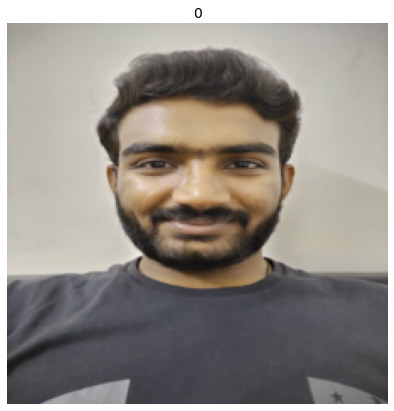

In [ ]:
# permute the image
per_img = img.permute(1,2,0)

# print different shape
print(f"Original image shape: {img.shape} --> [color_channel, height, width]")
print(f"Permuted image shape: {per_img.shape} --> [height, width, color_channel]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(per_img.squeeze(), cmap = 'gray')
plt.axis("off")
plt.title(class_names[label], fontsize=14);

## Load data in DataLoader

In [ ]:
# setup data loader
BATCH_SIZE = 8
train_dataloader = DataLoader(dataset = train_data, 
                              batch_size = BATCH_SIZE,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data, 
                             batch_size = BATCH_SIZE,
                             shuffle = True)

In [ ]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([8, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([8])


## Train Model loop

In [ ]:
# train
def train_loop(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer,
               accuracy_fn, device: torch.device = device):
  
  train_loss, train_acc = 0, 0
  for batch, (x_train, y_train) in enumerate(dataloader):

    if device == 'cuda':
      x_train, y_train = x_train.to(device), y_train.to(device)

    x_train.requires_grad = True

    model.train()

    # 1. Forward step
    pred = model(x_train)

    # 2. Loss
    loss = loss_fn(pred, y_train)

    # 3. Grad zerostep
    optimizer.zero_grad()

    # 4. Backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    acc = accuracy_fn(y_train, torch.argmax(pred, dim=1))
    train_loss += loss
    train_acc += acc

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc


# test
def test_loop(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module, accuracy_fn, 
              device: torch.device = device):
  
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for x_test, y_test in dataloader:

      if device == 'cuda':
        x_test, y_test = x_test.to(device), y_test.to(device)

      # 1. Forward
      test_pred = model(x_test)
      
      # 2. Loss and accuray
      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_test, torch.argmax(test_pred, dim=1))

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  return test_loss, test_acc

## Plot Graph

In [ ]:
def plot_graph(train_losses, test_losses, train_accs, test_accs):
  plt.figure(figsize = (20, 8))
  plt.subplot(1, 2, 1)
  plt.plot(range(len(train_losses)), train_losses, label = "Train Loss")
  plt.plot(range(len(test_losses)), test_losses, label = "Test Loss")
  plt.legend()
  plt.xlabel("Epoches")
  plt.ylabel("Loss")
  # plt.show()

  plt.subplot(1, 2, 2)
  plt.plot(range(len(train_accs)), train_accs, label = "Train Accuracy")
  plt.plot(range(len(test_accs)), test_accs, label = "Test Accuracy")
  plt.legend()
  plt.xlabel("Epoches")
  plt.ylabel("Accuracy")
  plt.show()

## Load Model

In [ ]:
model_18 = models.resnet18(pretrained = True)
num_ftrs = model_18.fc.in_features
# print(num_ftrs)
model_18.fc = nn.Linear(num_ftrs, 2)

# path
MODEL_PATH = Path("drive/MyDrive/Course/Sem2/DAI/Assignments/Assignment1")

MODEL_NAME = "ad_model.pth"
MODEL_PATH_SAVE = MODEL_PATH / MODEL_NAME

if torch.cuda.is_available() == False:
  model_18.load_state_dict(torch.load(f = MODEL_PATH_SAVE, map_location=torch.device('cpu')))
else:
  model_18.load_state_dict(torch.load(f = MODEL_PATH_SAVE))

# model_18.state_dict()

model_18 = model_18.to(device)

In [ ]:
## Loss, accuracy and optimizer
# Loss 
loss_fn = nn.CrossEntropyLoss()

# accuracy
accuracy_fn = MulticlassAccuracy(num_classes = 2).to(device)

# optimizer
optimizer = torch.optim.SGD(params = model_18.parameters(), lr = 0.001, momentum = 0.9)

In [ ]:
model18_train_loss, model18_test_loss = [], []
model18_train_accs, model18_test_accs = [], []
epoches = 5

torch.manual_seed(64)
torch.cuda.manual_seed(64)
for epoch in tqdm(range(epoches)):

  train_loss, train_acc = train_loop(model = model_18, dataloader = train_dataloader,
                                     loss_fn = loss_fn, optimizer = optimizer,
                                     accuracy_fn = accuracy_fn, device = device)
  
  test_loss, test_acc = test_loop(model = model_18, dataloader = test_dataloader,
                                  loss_fn = loss_fn, accuracy_fn = accuracy_fn,
                                  device = device)
  
  model18_train_loss.append(train_loss.item())
  model18_test_loss.append(test_loss.item())
  model18_train_accs.append(train_acc.item())
  model18_test_accs.append(test_acc.item())

  print(f"Epoch: {epoch+1}  Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Train Accuray: {train_acc:.4f} | Test Accuracy: {test_acc:.4f}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 0.7524 | Test Loss: 0.6880 | Train Accuray: 0.4310 | Test Accuracy: 0.4515
Epoch: 2  Train Loss: 0.1768 | Test Loss: 0.6267 | Train Accuray: 0.9464 | Test Accuracy: 0.6885
Epoch: 3  Train Loss: 0.2689 | Test Loss: 0.6482 | Train Accuray: 0.7976 | Test Accuracy: 0.6800
Epoch: 4  Train Loss: 0.0619 | Test Loss: 0.1616 | Train Accuray: 0.9286 | Test Accuracy: 0.9762
Epoch: 5  Train Loss: 0.0664 | Test Loss: 0.1163 | Train Accuray: 0.9048 | Test Accuracy: 1.0000


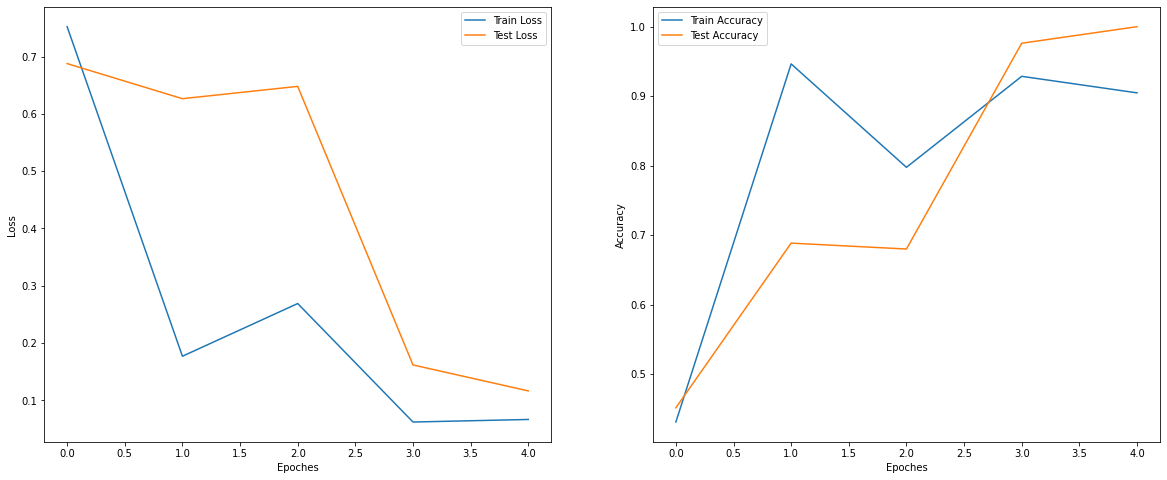

In [ ]:
plot_graph(model18_train_loss, model18_test_loss, model18_train_accs, model18_test_accs)